<a href="https://www.kaggle.com/code/averma111/stacking-crabage-s3e16?scriptVersionId=132705105" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%capture
!pip install plotly-express

In [2]:
# https://www.kaggle.com/code/averma111/pytorch-crabage-s3e16
import pandas as pd
import numpy as np 
import os
import warnings
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import xgboost
import plotly.express as px
warnings.filterwarnings('ignore')
seed = 42
np.random.seed(seed)


## Data Acquisition

In [3]:
class Acquisition:
    
    def __init__(self,root_path):
        self.root_path = root_path
        
    def get_dataframe(self,filename):
        return pd.read_csv(os.path.join(self.root_path,filename))
    
    def summary(self,text, df):
        summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
        summary['null'] = df.isnull().sum()
        summary['unique'] = df.nunique()
        summary['min'] = df.min()
        summary['median'] = df.median()
        summary['max'] = df.max()
        summary['mean'] = df.mean()
        summary['std'] = df.std()
        summary['duplicate'] = df.duplicated().sum()
        return summary
    
    def get_dataset_info(self,df):
            return df.info()
    
    
    
acq = Acquisition(root_path='/kaggle/input/playground-series-s3e16')
acq_original = Acquisition(root_path='/kaggle/input/crab-age-prediction')

## Train Dataset

In [4]:
train = acq.get_dataframe(filename='train.csv')
train=train.set_index('id')
train.head()

Sex  Length  Diameter  Height     Weight  Shucked Weight  Viscera Weight  \
id                                                                            
0    I  1.5250    1.1750  0.3750  28.973189       12.728926        6.647958   
1    I  1.1000    0.8250  0.2750  10.418441        4.521745        2.324659   
2    M  1.3875    1.1125  0.3750  24.777463       11.339800        5.556502   
3    F  1.7000    1.4125  0.5000  50.660556       20.354941       10.991839   
4    I  1.2500    1.0125  0.3375  23.289114       11.977664        4.507570   

    Shell Weight  Age  
id                     
0       8.348928    9  
1       3.401940    8  
2       6.662133    9  
3      14.996885   11  
4       5.953395    8

## Full Dataset

In [5]:
original = acq_original.get_dataframe(filename='CrabAgePrediction.csv')
original.head()

Sex  Length  Diameter  Height     Weight  Shucked Weight  Viscera Weight  \
0   F  1.4375    1.1750  0.4125  24.635715       12.332033        5.584852   
1   M  0.8875    0.6500  0.2125   5.400580        2.296310        1.374951   
2   I  1.0375    0.7750  0.2500   7.952035        3.231843        1.601747   
3   F  1.1750    0.8875  0.2500  13.480187        4.748541        2.282135   
4   I  0.8875    0.6625  0.2125   6.903103        3.458639        1.488349   

   Shell Weight  Age  
0      6.747181    9  
1      1.559222    6  
2      2.764076    6  
3      5.244657   10  
4      1.700970    6

## Summary of Datasets

In [6]:
acq.summary('train',train)

dtypes  null  unique       min     median        max  \
Sex              object     0       3         F        NaN          M   
Length          float64     0     144    0.1875   1.375000   2.012815   
Diameter        float64     0     122    0.1375   1.075000     1.6125   
Height          float64     0      65       0.0   0.362500      2.825   
Weight          float64     0    3096  0.056699  23.799405  80.101512   
Shucked Weight  float64     0    1766  0.028349   9.908150  42.184056   
Viscera Weight  float64     0     967  0.042524   4.989512   21.54562   
Shell Weight    float64     0    1048  0.042524   6.931453  28.491248   
Age               int64     0      28         1  10.000000         29   

                     mean        std  duplicate  
Sex                   NaN        NaN          0  
Length           1.317460   0.287757          0  
Diameter         1.024496   0.237396          0  
Height           0.348089   0.092034          0  
Weight          23.385217  12.648153          0  
Shucked Weight  10.104270   5.618025          0  
Viscera Weight   5.058386   2.792729          0  
Shell Weight     6.723870   3.584372          0  
Age              9.967806   3.175189          0

In [7]:
acq.summary('original',original)

dtypes  null  unique       min     median        max  \
Sex              object     0       3         F        NaN          M   
Length          float64     0     134    0.1875   1.362500     2.0375   
Diameter        float64     0     111    0.1375   1.062500      1.625   
Height          float64     0      51       0.0   0.362500      2.825   
Weight          float64     0    2343  0.056699  22.792998  80.101512   
Shucked Weight  float64     0    1482  0.028349   9.539607  42.184056   
Viscera Weight  float64     0     867  0.014175   4.861939   21.54562   
Shell Weight    float64     0     907  0.042524   6.662133  28.491248   
Age               int64     0      28         1  10.000000         29   

                     mean        std  duplicate  
Sex                   NaN        NaN          0  
Length           1.311306   0.300431          0  
Diameter         1.020893   0.248233          0  
Height           0.349374   0.104976          0  
Weight          23.567275  13.891201          0  
Shucked Weight  10.207342   6.275275          0  
Viscera Weight   5.136546   3.104133          0  
Shell Weight     6.795844   3.943392          0  
Age              9.954791   3.220967          0

In [8]:
fulldata = pd.concat([train,original])
acq.summary('fulldata',fulldata)

dtypes  null  unique       min     median        max  \
Sex              object     0       3         F        NaN          M   
Length          float64     0     146    0.1875   1.375000     2.0375   
Diameter        float64     0     123    0.1375   1.075000      1.625   
Height          float64     0      65       0.0   0.362500      2.825   
Weight          float64     0    3099  0.056699  23.728531  80.101512   
Shucked Weight  float64     0    1769  0.028349   9.879801  42.184056   
Viscera Weight  float64     0     970  0.014175   4.975337   21.54562   
Shell Weight    float64     0    1050  0.042524   6.874754  28.491248   
Age               int64     0      28         1  10.000000         29   

                     mean        std  duplicate  
Sex                   NaN        NaN          0  
Length           1.317153   0.288404          0  
Diameter         1.024316   0.237949          0  
Height           0.348154   0.092723          0  
Weight          23.394310  12.713088          0  
Shucked Weight  10.109418   5.652666          0  
Viscera Weight   5.062290   2.809131          0  
Shell Weight     6.727465   3.603159          0  
Age              9.967156   3.177472          0

## Exploratory Data Analysis


In [9]:
print(f'The information of fulldataset is:{acq.get_dataset_info(fulldata)}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77944 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             77944 non-null  object 
 1   Length          77944 non-null  float64
 2   Diameter        77944 non-null  float64
 3   Height          77944 non-null  float64
 4   Weight          77944 non-null  float64
 5   Shucked Weight  77944 non-null  float64
 6   Viscera Weight  77944 non-null  float64
 7   Shell Weight    77944 non-null  float64
 8   Age             77944 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 5.9+ MB
The information of fulldataset is:None


In [10]:
fig = px.pie(fulldata, values='Age', names='Sex', title='Distribution of Sex Vs Age',width=800, height=400)
fig.show()

In [11]:
fig = px.histogram(fulldata, x="Age", y=['Length','Diameter','Height','Weight','Shucked Weight',
                                         'Viscera Weight','Shell Weight'],width=800, height=400,
                   title='Age vs Crab Object',labels={
                     "Age": "Age in years"
                 })
fig.show()

## Segment Features and Labels

In [12]:
class Get_features_label:
    
    def get_features_label(self,df):
        
        features = df.loc[:, ~df.columns.isin(['Age'])]
        label = df['Age']
        
        return features,label
    
    
feat_label = Get_features_label()
feature,label=feat_label.get_features_label(fulldata)

## Segment Categorical and Numerical Columns

In [13]:
class Column_selector:
    
    def make_selector(self,feature):
        cat_selector = make_column_selector(dtype_include=object)
        num_selector = make_column_selector(dtype_include=np.float)
        return cat_selector,num_selector


cs = Column_selector()
cat_selector,num_selector = cs.make_selector(feature)

## Columnar Transformation

In [14]:
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff260239a20>)])

In [15]:
cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff260239a20>)])

## Model Selections

In [16]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff260239a20>)])),
                ('lassocv', LassoCV())])

In [17]:
from sklearn.linear_model import LinearRegression

linear_pipeline = make_pipeline(linear_preprocessor, LinearRegression())
linear_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff260239a20>)])),
                ('linearregression', LinearRegression())])

In [18]:
from sklearn.linear_model import Ridge
ridge_pipeline = make_pipeline(linear_preprocessor, Ridge(alpha=.5))
ridge_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff260239a20>)])),
                ('ridge', Ridge(alpha=0.5))])

In [19]:
from sklearn.linear_model import BayesianRidge
bayesridge_pipeline = make_pipeline(linear_preprocessor, BayesianRidge())
bayesridge_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff260239a20>)])),
                ('bayesianridge', BayesianRidge())])

In [20]:
from  xgboost import XGBRegressor
xgb_pipeline = make_pipeline(linear_preprocessor, XGBRegressor())
xgb_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff260239a20>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [22]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)
gbdt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff260239a20>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=0))])

## Stacking Estimators

In [23]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
    ('Xtreame Gradient Boosting',xgb_pipeline),
    ('Linear',linear_pipeline),
    ('Ridge',ridge_pipeline),
    ('BayesRidge',bayesridge_pipeline)
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_v...
                                                                                                 ('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff260239a20>)])),
                                               ('bayesianridge',
                                                BayesianRidge())]))],
                  final_estimator=LinearRegression())

## Plotting Best Estimators

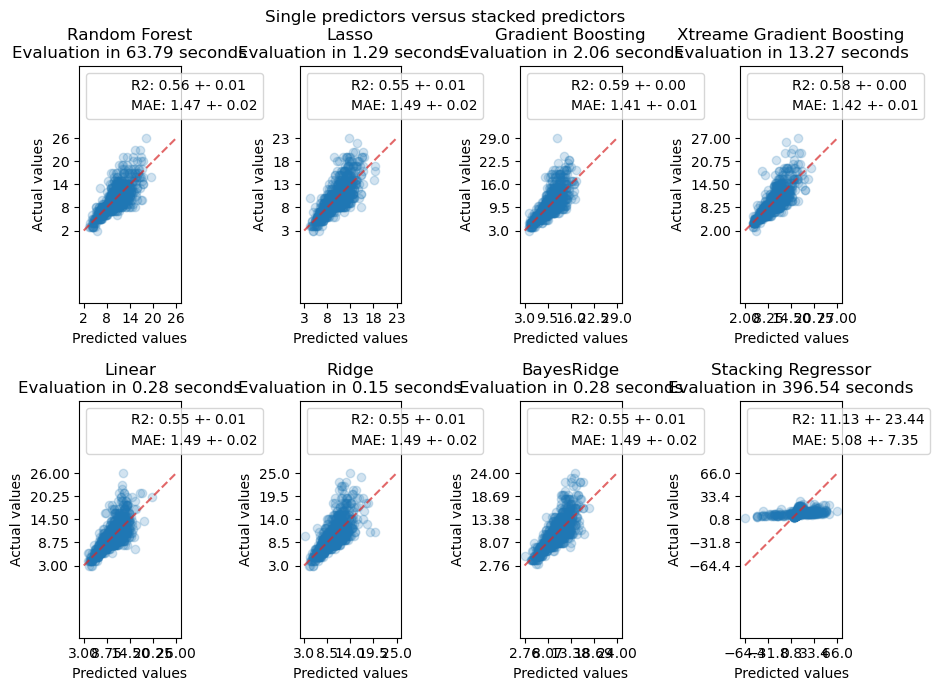

In [30]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_validate, cross_val_predict

fig, axs = plt.subplots(2, 4, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, feature, label, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, feature, label, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=label,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Predictions on Test Data

In [25]:
test = acq.get_dataframe(filename='test.csv')
test.head()

id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0  74051   I  1.0500    0.7625  0.2750   8.618248        3.657085   
1  74052   I  1.1625    0.8875  0.2750  15.507176        7.030676   
2  74053   F  1.2875    0.9875  0.3250  14.571643        5.556502   
3  74054   F  1.5500    0.9875  0.3875  28.377849       13.380964   
4  74055   I  1.1125    0.8500  0.2625  11.765042        5.528153   

   Viscera Weight  Shell Weight  
0        1.729319      2.721552  
1        3.246018      3.968930  
2        3.883882      4.819415  
3        6.548735      7.030676  
4        2.466407      3.331066

In [26]:
stacking_regressor.fit(feature,label)

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_v...
                                                                                                 ('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff26023bf40>),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff260239a20>)])),
                                               ('bayesianridge',
                                                BayesianRidge())]))],
                  final_estimator=LinearRegression())

In [27]:
test = acq.get_dataframe(filename='test.csv')
test.head()

id Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0  74051   I  1.0500    0.7625  0.2750   8.618248        3.657085   
1  74052   I  1.1625    0.8875  0.2750  15.507176        7.030676   
2  74053   F  1.2875    0.9875  0.3250  14.571643        5.556502   
3  74054   F  1.5500    0.9875  0.3875  28.377849       13.380964   
4  74055   I  1.1125    0.8500  0.2625  11.765042        5.528153   

   Viscera Weight  Shell Weight  
0        1.729319      2.721552  
1        3.246018      3.968930  
2        3.883882      4.819415  
3        6.548735      7.030676  
4        2.466407      3.331066

## Submission for Competition

In [28]:
yhat_age = stacking_regressor.predict(test)
df_submit = pd.DataFrame(data={'id': test['id'],'Age': yhat_age})
df_submit.to_csv('submission.csv', index=False)
print('Submission Completed!!')

Submission Completed!!
